In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Comparing groups

In [4]:
tips = sns.load_dataset('tips')
tips[-5:]

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


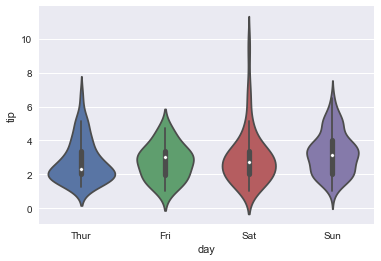

In [5]:
sns.violinplot(x='day', y='tip', data=tips)

In [6]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

In [10]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(np.unique(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(np.unique(idx)))
    
    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    
    trace_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -447.78: 100%|██████████| 200000/200000 [00:14<00:00, 14010.59it/s]
Finished [100%]: Average ELBO = -447.77
100%|██████████| 5000/5000 [00:05<00:00, 841.15it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1110e3630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11600aa58>]], dtype=object)

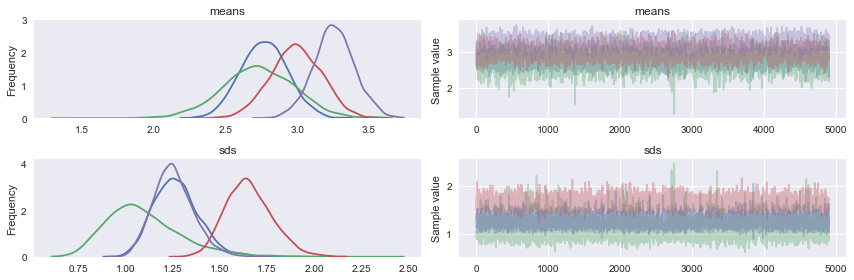

In [11]:
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

In [15]:
chain_cg['means'].shape

(4900, 4)

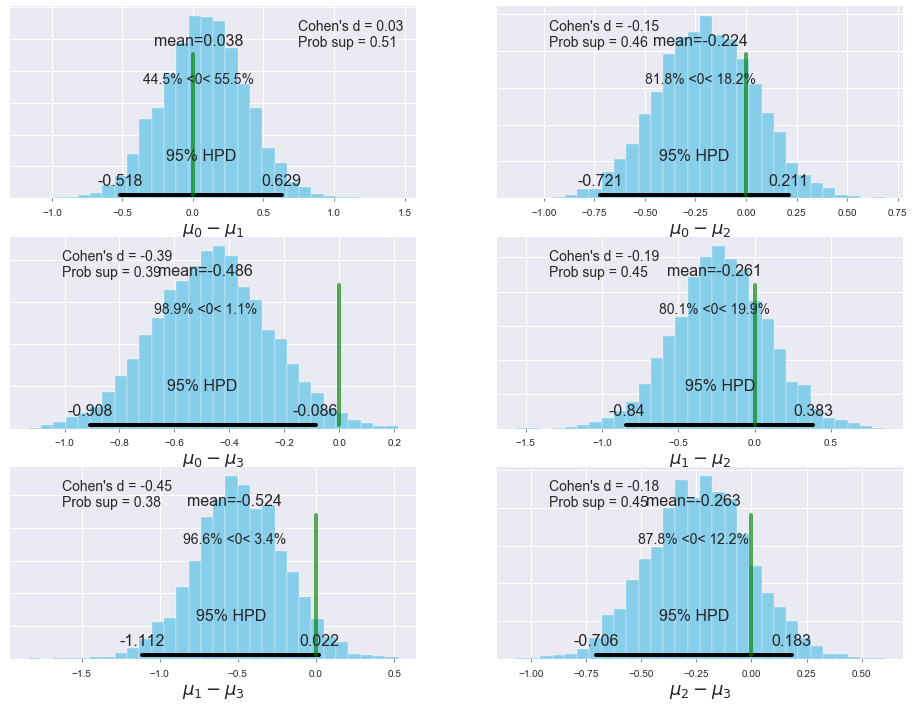

In [14]:
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16,12))

comparisons = [(i,j) for i in range(4) for j in range(i+1,4)]
pos = [(k,l) for k in range(3) for l in (0,1)]

for (i,j), (k,l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i] - chain_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen / (2**0.5))
    
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k,l], color='skyblue')
    ax[k,l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l].set_xlabel('$\mu_{}-\mu_{}$'.format(i,j), fontsize=18)
    ax[k,l].legend(loc=0, fontsize=14)

Pretty cool that we can calculate something like the "probability of superiority" - another kind of measure of effect size - just from the chain, instead of having to make assumptions about the distribution of the data as is typically done. The probability of superiority is the probability that a data point from one group has a larger value than a data point taken from the other group. We have a chain of valid values, so I think we just need to count the number of times the value is greater in one of the groups. For example: 

The exercises talk about using the sample_ppc function.

In [25]:
# i don't think i'm doing this correctly - using the data wrong?
sum(chain_cg['means'][:,0] > chain_cg['means'][:,1]) / len(chain_cg)

0.55530612244897959

# Hierarchical models

In [55]:
def get_group_and_booleans(N_samples, G_samples):
    group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
    data = []
    for i in range(0, len(N_samples)):
        data.extend(np.repeat([1,0], 
                              [G_samples[i], N_samples[i]-G_samples[i]]))
        
    return group_idx, data

In [59]:
def get_chain(group_idx, booleans):
    with pm.Model() as model_h:
        alpha = pm.HalfCauchy('alpha', beta=10)
        beta = pm.HalfCauchy('beta', beta=10)

        theta = pm.Beta('theta', alpha, beta, shape=len(np.unique(group_idx)))

        y = pm.Bernoulli('y', p=theta[group_idx], observed=booleans)

        trace_h = pm.sample(2000)
        
    return trace_h[200:]

In [65]:
chain_30and18 = get_chain(*get_group_and_booleans([30, 30, 30], [18, 18, 18]))

/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...

Average ELBO = -65.326: 100%|██████████| 200000/200000 [00:20<00:00, 9832.86it/s] 
Finished [100%]: Average ELBO = -65.305
100%|██████████| 2000/2000 [00:08<00:00, 231.09it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119e2f780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1181d6470>]], dtype=object)

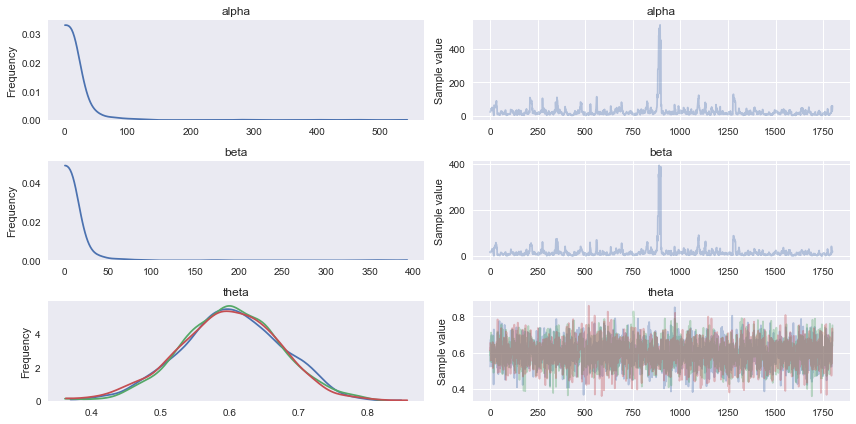

In [66]:
pm.traceplot(chain_30and18)

In [67]:
pm.df_summary(chain_30and18)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,24.215719,41.916638,3.632433,0.969113,62.336314
beta,16.376770,31.570165,2.734404,0.643938,41.490594
theta__0,0.601669,0.072573,0.001890,0.465610,0.740311
theta__1,0.601523,0.070424,0.002007,0.457994,0.732940
theta__2,0.597401,0.073470,0.001902,0.451209,0.735624


/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -34.11: 100%|██████████| 200000/200000 [00:19<00:00, 10017.63it/s] 
Finished [100%]: Average ELBO = -34.118
100%|██████████| 2000/2000 [00:09<00:00, 222.20it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,7.176492,7.612432,0.458493,0.052639,21.586286
beta,64.236587,78.349206,4.728176,0.720214,214.442266
theta__0,0.106227,0.043912,0.001334,0.025849,0.192556
theta__1,0.106152,0.043495,0.001456,0.028961,0.190027
theta__2,0.106296,0.043560,0.001464,0.033192,0.197568


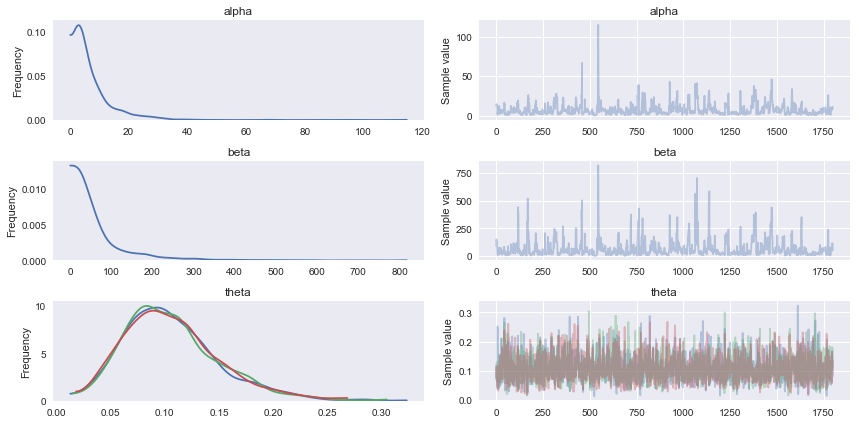

In [68]:
chain_30and3 = get_chain(*get_group_and_booleans([30, 30, 30], [3, 3, 3]))
pm.traceplot(chain_30and3)
pm.df_summary(chain_30and3)

/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -47.995: 100%|██████████| 200000/200000 [00:19<00:00, 10205.89it/s]
Finished [100%]: Average ELBO = -47.981
100%|██████████| 2000/2000 [00:05<00:00, 334.12it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.550388,1.787189,0.087432,0.267908,5.670537
beta,6.994594,5.083984,0.261242,0.218121,15.946601
theta__0,0.525753,0.089380,0.002928,0.351961,0.693120
theta__1,0.138395,0.059437,0.001567,0.027687,0.250000
theta__2,0.139556,0.058975,0.001644,0.035862,0.246431


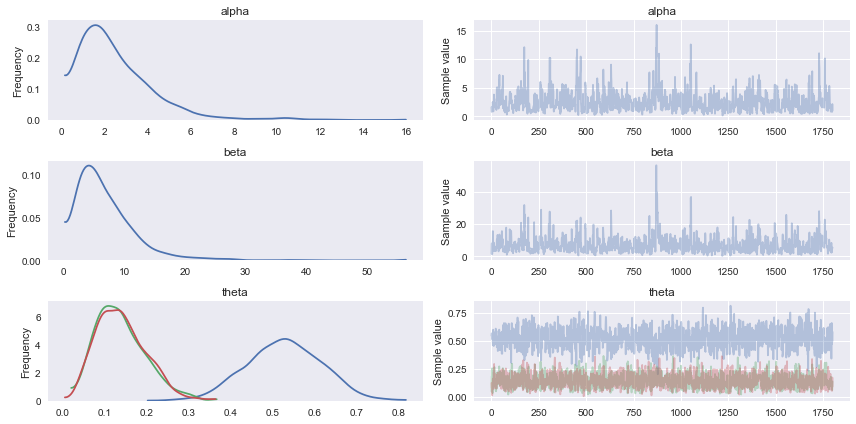

In [69]:
chain_30and18and3 = get_chain(*get_group_and_booleans([30, 30, 30], [18, 3, 3]))
pm.traceplot(chain_30and18and3)
pm.df_summary(chain_30and18and3)

Ok, so we have a chain of many different probable parameters - a set mus for the different groups, for example. The alphas and betas define a beta distribution that the Bernoulli likelihood uses as its prior. What does that beta distribution look like, for 100 randomly selected points in the chain? And then what's the single beta distribution that's an average of the all of the points in the chain? (I think Kruschke would step through the chain and use a row every certain number of steps... does that look different?)

In [76]:
def plot_beta_distributions(chain):
    x = np.linspace(0, 1, 100)
    for i in np.random.randint(0, len(chain), size=100):
        pdf = stats.beta(chain['alpha'][i], 
                         chain['beta'][i]).pdf(x)
        plt.plot(x, pdf, 'g', alpha=0.05)
        
    dist = stats.beta(chain['alpha'].mean(), chain['beta'].mean())
    pdf = dist.pdf(x)
    mode = x[np.argmax(pdf)]
    mean = dist.moment(1)
    plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))
    
    plt.legend(fontsize=14)
    plt.xlabel(r'$\theta_{prior}$', fontsize=16)

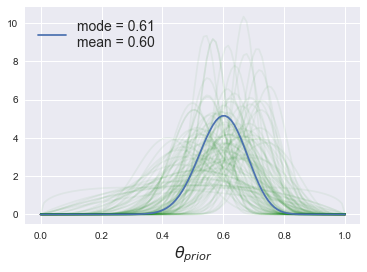

In [77]:
plot_beta_distributions(chain_30and18)

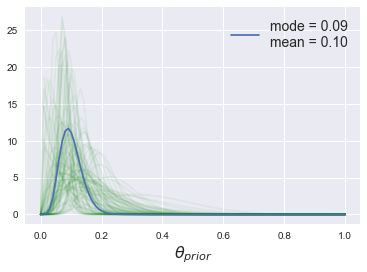

In [78]:
plot_beta_distributions(chain_30and3)

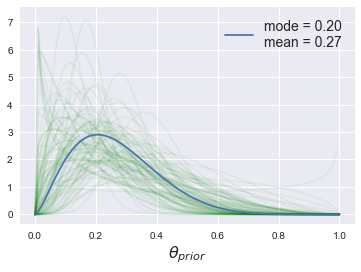

In [80]:
# this one doesn't make sense because we have different thetas
# but I'll plot it anyway
plot_beta_distributions(chain_30and18and3)

In [81]:
pm.sample_ppc?